In [1]:
import torch
from torch_geometric.data import Dataset, Data  # Ensure both Dataset and Data are imported
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import logging
import warnings
from rdkit import RDLogger
from sklearn.preprocessing import MinMaxScaler
# Suppress all warnings
warnings.filterwarnings("ignore")
# Suppress RDKit-specific warnings
RDLogger.DisableLog('rdApp.*')

# Configure logging
#logging.basicConfig(filename="logs/pipeline.log", level=logging.INFO, format="%(asctime)s - %(message)s")


In [2]:
test = pd.read_csv("D:/PropPredictionModel/PropPredictionModel/tests/toxicity/data/test_tox_data.csv")
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]
test

,IDs,SMILES,Labels
0,NCGC00261443-01,CNC1=C2N=CN([C@@H]3O[C@H](CO)C(O)[C@H]3O)C2=NC=N1,0
1,NCGC00261600-01,OC1=CC(\C=C\C2=CC=C(O)C(O)=C2)=CC(O)=C1,1
2,NCGC00260926-01,[Cl-].COC1=CC=C2C3=CC=C4C=C5OCOC5=CC4=C3[N+](C...,0
3,NCGC00261266-01,Br.CC1=C(CC(N)C(O)=O)C(O)=NO1,0
4,NCGC00261559-01,C1C(CC2=C1C=CC=C2)N3CCN(CC3)C4=CC=CC5=C4OCCO5,0
...,...,...,...
260,NCGC00261317-01,COC1=C(O)C=CC(CC(O)=O)=C1,0
261,NCGC00261138-01,CCCCCCN(CCCCCC)C(=O)CC1=C(NC2=C1C=CC=C2)C3=CC=...,0
262,NCGC00261292-01,Cl.NCCC1=CNC2=C1C=C(O)C=C2,0
263,NCGC00260828-01,CC(\C=C\C=C(C)\C=C\C1=C(C)C(O)C(=O)CC1(C)C)=C\...,0


In [3]:
train = pd.read_csv('New_train.csv')
val = pd.read_csv('New_val.csv')
test = pd.read_csv('New_test.csv')

train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
val = val.loc[:, ~val.columns.str.contains('^Unnamed')]
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]

common_entries = pd.merge(test, train, on=['Canonical SMILES', 'Standardized_SMILES'], how='inner')
# Display the common entries
common_entries

In [4]:
train

,Canonical_SMILES,Standardized_SMILES,Toxicity_Value
0,C[S+](C)CCC(N)C(=O)O.[Cl-],C[S+](C)CCC(N)C(=O)O,0
1,COc1ccc(C(=O)N2CCC3(CC2)CCN(c2ccccn2)CC3)cc1,COc1ccc(C(=O)N2CCC3(CC2)CCN(c2ccccn2)CC3)cc1,0
2,CC(=O)OCC(=O)NCCCOc1cccc(CN2CCCCC2)c1.Cl,CC(=O)OCC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1
3,CC(=O)NCCNc1nc(-c2ccc(N(C)C)cc2)nc2ccccc12,CC(=O)NCCNc1nc(-c2ccc(N(C)C)cc2)nc2ccccc12,0
4,CCOCC(=O)Nc1cc(C(F)(F)F)ccc1Oc1cccc(Br)c1,CCOCC(=O)Nc1cc(C(F)(F)F)ccc1Oc1cccc(Br)c1,1
...,...,...,...
9923,Fc1ccc(Nc2ccnc(-c3ccccc3C(F)(F)F)n2)cc1,Fc1ccc(Nc2ccnc(-c3ccccc3C(F)(F)F)n2)cc1,1
9924,CC(C)CN1CCC2(CC1)CCN(S(=O)(=O)c1ccccc1)CC2,CC(C)CN1CCC2(CC1)CCN(S(=O)(=O)c1ccccc1)CC2,0
9925,C=C[C@H](N)CCC(=O)O,C=C[C@H](N)CCC(=O)O,0
9926,O=C(CCS(=O)(=O)c1cccs1)N1CCN(c2ccc(F)cc2)CC1,O=C(CCS(=O)(=O)c1cccs1)N1CCN(c2ccc(F)cc2)CC1,1


train = train.rename(columns={'Canonical SMILES': 'Canonical_SMILES', 'Toxicity Value': 'Toxicity_Value'})
val = train.rename(columns={'Canonical SMILES': 'Canonical_SMILES', 'Toxicity Value': 'Toxicity_Value'})
test = train.rename(columns={'Canonical SMILES': 'Canonical_SMILES', 'Toxicity Value': 'Toxicity_Value'})

train.to_csv('New_train.csv', index=False)
val.to_csv('New_val.csv', index=False)
test.to_csv('New_test.csv', index=False)

In [5]:
train

,Canonical_SMILES,Standardized_SMILES,Toxicity_Value
0,C[S+](C)CCC(N)C(=O)O.[Cl-],C[S+](C)CCC(N)C(=O)O,0
1,COc1ccc(C(=O)N2CCC3(CC2)CCN(c2ccccn2)CC3)cc1,COc1ccc(C(=O)N2CCC3(CC2)CCN(c2ccccn2)CC3)cc1,0
2,CC(=O)OCC(=O)NCCCOc1cccc(CN2CCCCC2)c1.Cl,CC(=O)OCC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1
3,CC(=O)NCCNc1nc(-c2ccc(N(C)C)cc2)nc2ccccc12,CC(=O)NCCNc1nc(-c2ccc(N(C)C)cc2)nc2ccccc12,0
4,CCOCC(=O)Nc1cc(C(F)(F)F)ccc1Oc1cccc(Br)c1,CCOCC(=O)Nc1cc(C(F)(F)F)ccc1Oc1cccc(Br)c1,1
...,...,...,...
9923,Fc1ccc(Nc2ccnc(-c3ccccc3C(F)(F)F)n2)cc1,Fc1ccc(Nc2ccnc(-c3ccccc3C(F)(F)F)n2)cc1,1
9924,CC(C)CN1CCC2(CC1)CCN(S(=O)(=O)c1ccccc1)CC2,CC(C)CN1CCC2(CC1)CCN(S(=O)(=O)c1ccccc1)CC2,0
9925,C=C[C@H](N)CCC(=O)O,C=C[C@H](N)CCC(=O)O,0
9926,O=C(CCS(=O)(=O)c1cccs1)N1CCN(c2ccc(F)cc2)CC1,O=C(CCS(=O)(=O)c1cccs1)N1CCN(c2ccc(F)cc2)CC1,1


In [6]:
def get_edge_features(mol, conformer):
    edge_features = []
    edge_indices = []

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        bond_length = conformer.GetAtomPosition(i).Distance(conformer.GetAtomPosition(j))

        edge_features.append([
            int(bond.GetBondTypeAsDouble()),  # Bond type as double
            bond.GetIsConjugated(),          # Is conjugated (True/False)
            bond_length                      # Bond length
        ])
        # Add both directions (undirected graph)
        edge_indices.append((i, j))
        edge_indices.append((j, i))

    edge_indices = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_features = torch.tensor(edge_features * 2, dtype=torch.float)  # Duplicate for both directions
    return edge_indices, edge_features

In [37]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

def get_node_features(mol, unique_atomic_numbers):
    """
    Generate node features for a molecule, including one-hot encoding for atomic numbers and normalized additional features.

    Args:
        mol: RDKit molecule object.
        unique_atomic_numbers: List of unique atomic numbers in the dataset.

    Returns:
        torch.Tensor: Node feature matrix.
    """
    one_hot_encoded = []
    additional_features = []

    for atom in mol.GetAtoms():
        # Atomic number (categorical - one-hot encoded)
        atomic_number = atom.GetAtomicNum()
        one_hot_encoded.append([atomic_number])

        # Additional features
        additional_features.append([
            int(atom.GetIsAromatic()),          # Aromaticity (0/1)
            atom.GetDegree(),                   # Atom degree (int)
            atom.GetTotalValence(),             # Total valence electrons (int)
            atom.GetFormalCharge(),             # Formal charge (int)
            int(atom.GetHybridization()),       # Hybridization as integer enum
        ])

    # Convert atomic numbers to one-hot encoding
    one_hot_encoded = np.array(one_hot_encoded).reshape(-1, 1)
    encoder = OneHotEncoder(categories=[unique_atomic_numbers], sparse_output=False, handle_unknown="ignore")
    one_hot_encoded = encoder.fit_transform(one_hot_encoded)

    # Normalize additional features
    additional_features = np.array(additional_features, dtype=np.float32)
    scaler = MinMaxScaler()
    normalized_additional_features = scaler.fit_transform(additional_features)

    # Concatenate one-hot encoded atomic numbers with normalized additional features
    node_features = np.hstack((one_hot_encoded, normalized_additional_features))

    return torch.tensor(node_features, dtype=torch.float)


In [38]:
def molecule_to_graph(smiles, target, unique_atomic_numbers):
    """
    Converts a SMILES string into a PyTorch Geometric Data object.
    
    Args:
        smiles (str): SMILES string.
        target (float): Target property value.
        unique_atomic_numbers (list[int]): List of unique atomic numbers.

    Returns:
        Data: A PyTorch Geometric Data object with x, edge_index, edge_attr, pos, and y.
    """
    #try:
    # Create RDKit molecule object
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES string: {smiles}")

    # Add hydrogens
    mol = Chem.AddHs(mol)

    # Generate 3D conformer
    status = AllChem.EmbedMolecule(mol)
    if status != 0:
        raise ValueError(f"Conformer generation failed for SMILES: {smiles}")

    conformer = mol.GetConformer()

    # Get node features
    x = get_node_features(mol, unique_atomic_numbers)

    # Get edge features and indices
    edge_index, edge_attr = get_edge_features(mol, conformer)
    #scaler = MinMaxScaler()
    #edge_attr = scaler.fit_transform(edge_attr)

    # Get 3D positions
    pos = torch.tensor([[conformer.GetAtomPosition(i).x,
                         conformer.GetAtomPosition(i).y,
                         conformer.GetAtomPosition(i).z] for i in range(mol.GetNumAtoms())], dtype=torch.float)

    # Add target property
    y = torch.tensor([target], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, pos=pos, y=y)

    #except Exception as e:
    #   logging.error(f"Error processing molecule: {smiles}, Error: {e}")
    #    return None


In [39]:
class MoleculeDataset(Dataset):
    def __init__(self, data_frame, unique_atomic_numbers, indices=None):
        """
        Custom dataset for molecular graphs.

        Args:
            data_frame (pd.DataFrame): DataFrame with columns ['smiles', 'target'].
            unique_atomic_numbers (list[int]): List of unique atomic numbers in the dataset.
            indices (list[int], optional): List of indices to use as a subset of the dataset.
        """
        super().__init__()
        self.data_frame = data_frame
        self.unique_atomic_numbers = unique_atomic_numbers
        self._indices = indices if indices is not None else range(len(data_frame))

    def len(self):
        """
        Returns the number of examples in the dataset.
        """
        return len(self._indices)

    def get(self, idx):
        """
        Returns the data object (graph) for a given index.

        Args:
            idx (int): Index of the data to retrieve.

        Returns:
            Data: A PyTorch Geometric Data object.
        """
        actual_idx = self._indices[idx]
        smiles = self.data_frame.iloc[actual_idx]['Canonical_SMILES']
        target = self.data_frame.iloc[actual_idx]['Toxicity_Value']
        print(smiles,target)
        return molecule_to_graph(smiles, target, self.unique_atomic_numbers)


In [40]:
def get_unique_atomic_numbers(dataset_smiles):
    """
    Identify unique atomic numbers (elements) in the dataset.

    Args:
        dataset_smiles (list[str]): List of SMILES strings in the dataset.

    Returns:
        list[int]: Sorted list of unique atomic numbers.
    """
    unique_atoms = set()
    for smiles in dataset_smiles:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            for atom in mol.GetAtoms():
                unique_atoms.add(atom.GetAtomicNum())
    return sorted(unique_atoms)


In [41]:
train

,Canonical_SMILES,Standardized_SMILES,Toxicity_Value
0,C[S+](C)CCC(N)C(=O)O.[Cl-],C[S+](C)CCC(N)C(=O)O,0
1,COc1ccc(C(=O)N2CCC3(CC2)CCN(c2ccccn2)CC3)cc1,COc1ccc(C(=O)N2CCC3(CC2)CCN(c2ccccn2)CC3)cc1,0
2,CC(=O)OCC(=O)NCCCOc1cccc(CN2CCCCC2)c1.Cl,CC(=O)OCC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1
3,CC(=O)NCCNc1nc(-c2ccc(N(C)C)cc2)nc2ccccc12,CC(=O)NCCNc1nc(-c2ccc(N(C)C)cc2)nc2ccccc12,0
4,CCOCC(=O)Nc1cc(C(F)(F)F)ccc1Oc1cccc(Br)c1,CCOCC(=O)Nc1cc(C(F)(F)F)ccc1Oc1cccc(Br)c1,1
...,...,...,...
9923,Fc1ccc(Nc2ccnc(-c3ccccc3C(F)(F)F)n2)cc1,Fc1ccc(Nc2ccnc(-c3ccccc3C(F)(F)F)n2)cc1,1
9924,CC(C)CN1CCC2(CC1)CCN(S(=O)(=O)c1ccccc1)CC2,CC(C)CN1CCC2(CC1)CCN(S(=O)(=O)c1ccccc1)CC2,0
9925,C=C[C@H](N)CCC(=O)O,C=C[C@H](N)CCC(=O)O,0
9926,O=C(CCS(=O)(=O)c1cccs1)N1CCN(c2ccc(F)cc2)CC1,O=C(CCS(=O)(=O)c1cccs1)N1CCN(c2ccc(F)cc2)CC1,1


In [48]:
dataset_smiles = train["Canonical_SMILES"].tolist()  # List of SMILES from the DataFrame
unique_atomic_numbers = get_unique_atomic_numbers(dataset_smiles)
len(unique_atomic_numbers)

37

In [52]:
dataset_smiles = val["Canonical_SMILES"].tolist()  # List of SMILES from the DataFrame
unique_atomic_numbers_val = get_unique_atomic_numbers(dataset_smiles)
len(unique_atomic_numbers_val)

18

In [49]:
dataset_smiles = test["Canonical_SMILES"].tolist()  # List of SMILES from the DataFrame
unique_atomic_numbers_test = get_unique_atomic_numbers(dataset_smiles)
len(unique_atomic_numbers_test)

15

In [55]:
# Assuming unique_atomic_numbers, unique_atomic_numbers_val, unique_atomic_numbers_test are defined
unique_atomic_numbers_combined = set(unique_atomic_numbers) | set(unique_atomic_numbers_val) | set(unique_atomic_numbers_test)

# Convert to a sorted list
sorted_unique_atomic_numbers = sorted(unique_atomic_numbers_combined)
print(sorted_unique_atomic_numbers)


[1, 3, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 44, 46, 48, 50, 53, 56, 60, 78, 79, 80, 81, 83]


In [54]:
len(set(unique_atomic_numbers_val) - set(unique_atomic_numbers))

3

In [43]:
dataset = MoleculeDataset(train, unique_atomic_numbers)


In [46]:
# Iterate over individual graphs
for graph in dataset:
    print(graph)
    print(f"Node features:\n{graph.x.shape}")
    print(f"Edge indices:\n{graph.edge_index.shape}")
    print(f"Edge features:\n{graph.edge_attr.shape}")
    print(f"Graph label (target):\n{graph.y}")
    print(f"3D positions (if available):\n{graph.pos.shape}")
    print("-----")


C[S+](C)CCC(N)C(=O)O.[Cl-] 0
Data(x=[25, 42], edge_index=[2, 46], edge_attr=[46, 3], y=[1], pos=[25, 3])
Node features:
torch.Size([25, 42])
Edge indices:
torch.Size([2, 46])
Edge features:
torch.Size([46, 3])
Graph label (target):
tensor([0.])
3D positions (if available):
torch.Size([25, 3])
-----
COc1ccc(C(=O)N2CCC3(CC2)CCN(c2ccccn2)CC3)cc1 0
Data(x=[54, 42], edge_index=[2, 114], edge_attr=[114, 3], y=[1], pos=[54, 3])
Node features:
torch.Size([54, 42])
Edge indices:
torch.Size([2, 114])
Edge features:
torch.Size([114, 3])
Graph label (target):
tensor([0.])
3D positions (if available):
torch.Size([54, 3])
-----
CC(=O)OCC(=O)NCCCOc1cccc(CN2CCCCC2)c1.Cl 1
Data(x=[55, 42], edge_index=[2, 110], edge_attr=[110, 3], y=[1], pos=[55, 3])
Node features:
torch.Size([55, 42])
Edge indices:
torch.Size([2, 110])
Edge features:
torch.Size([110, 3])
Graph label (target):
tensor([1.])
3D positions (if available):
torch.Size([55, 3])
-----
CC(=O)NCCNc1nc(-c2ccc(N(C)C)cc2)nc2ccccc12 0
Data(x=[49, 42]

KeyboardInterrupt: 

In [ ]:
def summarize_edge_attr(edge_attr):
    """
    Summarizes edge attributes by calculating basic statistics.

    Args:
        edge_attr (torch.Tensor): Edge attribute matrix.

    Returns:
        dict: Summary statistics for each edge feature.
    """
    summary = {}
    edge_attr_np = edge_attr.numpy()
    for i in range(edge_attr.shape[1]):  # Iterate over each feature
        feature = edge_attr_np[:, i]
        summary[f"Feature {i}"] = {
            "mean": feature.mean(),
            "std": feature.std(),
            "min": feature.min(),
            "max": feature.max(),
        }
    return summary

# Example usage
summary = summarize_edge_attr(graph.edge_attr)
for feature, stats in summary.items():
    print(f"{feature}: {stats}")


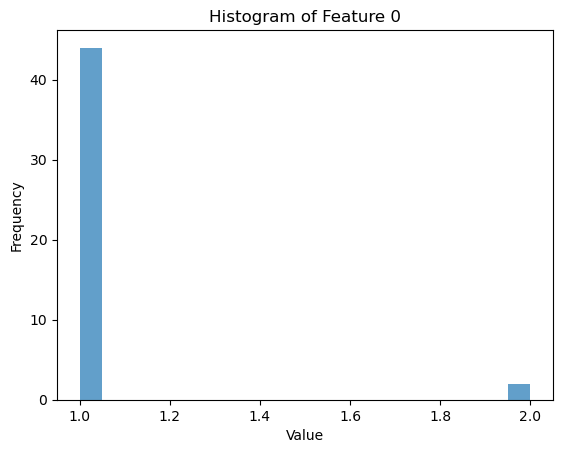

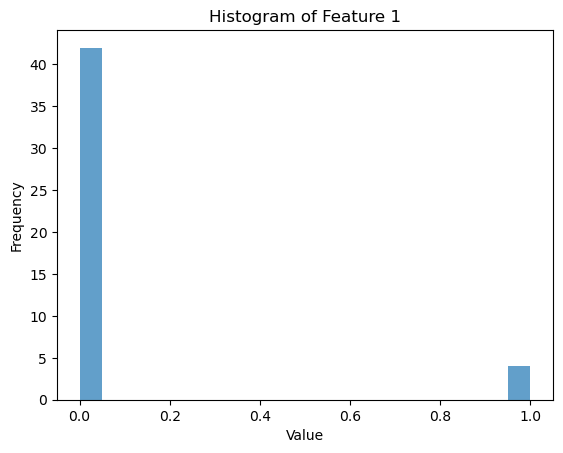

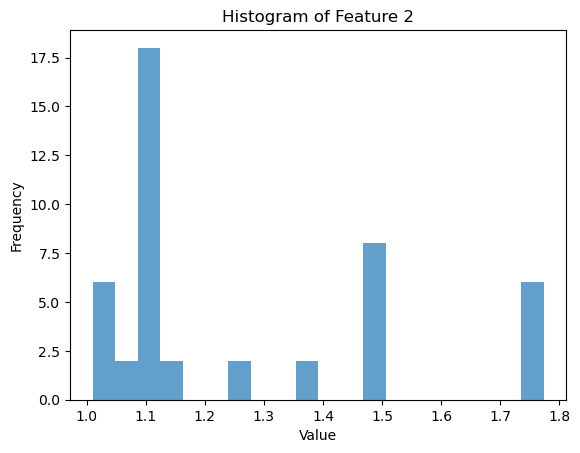

In [32]:
import matplotlib.pyplot as plt

def plot_edge_attr_histograms(edge_attr, feature_names=None):
    """
    Plots histograms for each edge attribute feature.

    Args:
        edge_attr (torch.Tensor): Edge attribute matrix.
        feature_names (list[str], optional): Names for edge features.
    """
    num_features = edge_attr.shape[1]
    edge_attr_np = edge_attr.numpy()
    feature_names = feature_names or [f"Feature {i}" for i in range(num_features)]

    for i in range(num_features):
        plt.figure()
        plt.hist(edge_attr_np[:, i], bins=20, alpha=0.7)
        plt.title(f"Histogram of {feature_names[i]}")
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.show()

# Example usage
plot_edge_attr_histograms(graph.edge_attr)


In [33]:
import networkx as nx
from torch_geometric.utils import to_networkx

def visualize_graph_with_edge_attr(data, edge_feature_index=0):
    """
    Visualizes the graph with edge attributes as labels.

    Args:
        data (torch_geometric.data.Data): PyTorch Geometric Data object.
        edge_feature_index (int): Index of the edge feature to visualize.
    """
    G = to_networkx(data, to_undirected=True)
    edge_attr_np = data.edge_attr.numpy()

    # Assign edge attributes as labels
    edge_labels = {
        (u, v): f"{edge_attr_np[i, edge_feature_index]:.2f}"
        for i, (u, v) in enumerate(G.edges)
    }

    pos = nx.spring_layout(G)  # Layout for visualization
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title(f"Edge Feature {edge_feature_index} Visualization")
    plt.show()

# Example usage
visualize_graph_with_edge_attr(data, edge_feature_index=0)


NameError: name 'data' is not defined